# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
787,business,lse sets date for takeover deal the london s...
738,tech,us duo in first spam conviction a brother and ...
2011,business,fiat mulls ferrari market listing ferrari coul...
1558,sport,wenger shock at newcastle dip arsenal manager ...
433,sport,benitez issues warning to gerrard liverpool ma...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re 

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

from nltk.stem import PorterStemmer

porter = PorterStemmer()

# Split a text into list of words
def tokenizer(text):
    return text.split()

# Split a text into list of words and apply stemming technic
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [8]:
X_data = bbc['text']
Y_data = bbc['category']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size = 0.2, random_state = 42)

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_LE = label_encoder.fit_transform(y_train)
y_test_LE = label_encoder.transform(y_test)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stop_words,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
model = SVC()
parameters = {'C': [0.1,1,10,20,100],
             'gamma': [1e-3,1e-2,1e-1,1]}
gridsearch = GridSearchCV(estimator=model,
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=5,n_jobs=-1)
gridsearch.fit(X_train_tfidf,y_train_LE)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 20, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [41]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.9786516853932584
{'C': 100, 'gamma': 0.01}


In [42]:
best_model = gridsearch.best_estimator_

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score
predictions = best_model.predict(X_test_tfidf)
print('Accuracy Score:', accuracy_score(y_test_LE, predictions))

Accuracy Score: 0.9685393258426966


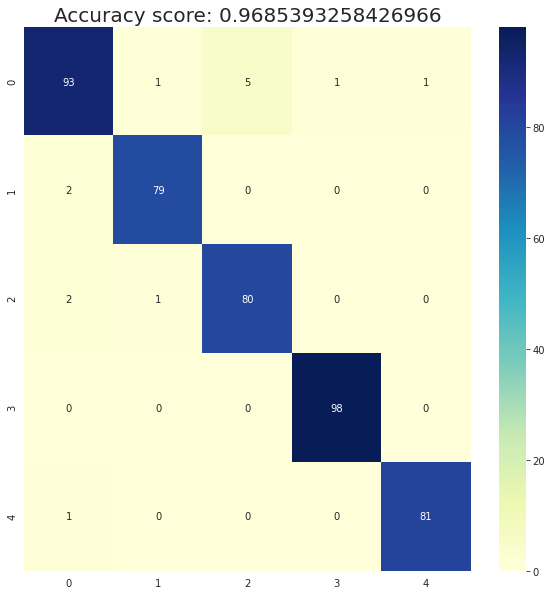

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test_LE, predictions), cmap="YlGnBu", annot=True, fmt="d")
plt.title(f'Accuracy score: {accuracy_score(y_test_LE, predictions)}', fontsize=20)
plt.show()